<a href="https://colab.research.google.com/github/davideneffat/movie_recommendations/blob/main/movielens_node2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
urlretrieve( "http://files.grouplens.org/datasets/movielens/ml-20m.zip", "movielens.zip")  #20m dataset
#urlretrieve( "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip")  #100k dataset
ZipFile("movielens.zip", "r").extractall()

In [ ]:
movies = pd.read_csv("ml-20m/movies.csv")###############################################
#movies = pd.read_csv("ml-latest-small/movies.csv")
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")  #create id column as movie_x

ratings = pd.read_csv("ml-20m/ratings.csv")###############################################
#ratings = pd.read_csv("ml-latest-small/ratings.csv")
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")  #create id column as movie_x

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (27278, 3)
Ratings data shape: (20000263, 4)


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,movie_2,3.5,1112486027
1,1,movie_29,3.5,1112484676
2,1,movie_32,3.5,1112484819
3,1,movie_47,3.5,1112484727
4,1,movie_50,3.5,1112484580


In [ ]:
movies

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,movie_131254,Kein Bund für's Leben (2007),Comedy
27274,movie_131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,movie_131258,The Pirates (2014),Adventure
27276,movie_131260,Rentun Ruusu (2001),(no genres listed)


In [ ]:
merged = pd.merge(ratings, movies, on='movieId', how='left')
merged.head()

,userId,movieId,rating,timestamp,title,genres
0,1,movie_2,3.5,1112486027,Jumanji (1995),Adventure|Children|Fantasy
1,1,movie_29,3.5,1112484676,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,movie_32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,movie_47,3.5,1112484727,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,movie_50,3.5,1112484580,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


<ipython-input-156-ba2b436899b0>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


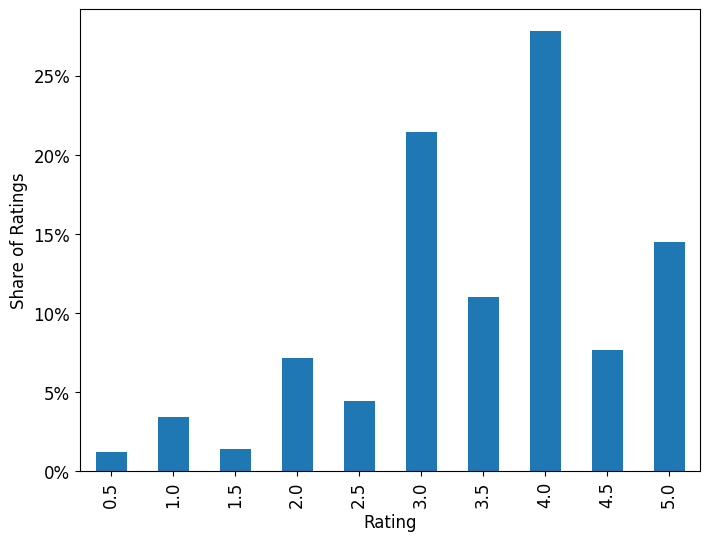

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = ratings.rating.value_counts(True).sort_index().plot.bar(figsize=(8,6))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Share of Ratings', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('Ratings_distribution.png')

In [ ]:
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]


def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

In [ ]:
min_rating = 4  #we only consider ratings grater than min_rating
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

rated_movies = ratings[ratings.rating >= min_rating]# Filter ratings
#print(rated_movies.head())

movies_grouped_by_users = list(rated_movies.groupby("userId")) #group instances by user.
print(movies_grouped_by_users[:1])
print(len(movies_grouped_by_users))

for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])

    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1 #update single movie frequency
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j]) #x and y to count only one time (a,b) and (b,a)
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1 #update pair of movies frequency
#print(len(pair_frequency))

[(1,      userId      movieId  rating   timestamp
6         1    movie_151     4.0  1094785734
7         1    movie_223     4.0  1112485573
8         1    movie_253     4.0  1112484940
9         1    movie_260     4.0  1112484826
10        1    movie_293     4.0  1112484703
..      ...          ...     ...         ...
168       1   movie_8368     4.0  1112485688
170       1   movie_8507     5.0  1094786027
171       1   movie_8636     4.5  1112485493
173       1   movie_8961     4.0  1112485629
174       1  movie_31696     4.0  1112485748

[88 rows x 4 columns])]
138287


Compute movie rating frequencies: 100%|██████████| 138287/138287 [35:36<00:00, 64.74it/s]


In [ ]:
#create our grapg
min_weight = 0.5

movies_graph = nx.Graph() #undirected
# let's add weighted edges between movies.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    #let's compute intersection over union
    x, y = pair #pair of movies
    xy_intersection = pair_frequency[pair] #intersection of x and y: users who saw both movies and reviewed them >= 4
    x_frequency = item_frequency[x] #users that saw movie x
    y_frequency = item_frequency[y] #users that saw movie y
    IoU = xy_intersection / (x_frequency + y_frequency)
    weight = IoU * xy_intersection #to not have value too small
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Creating the movie graph:  18%|█▊        | 9020040/48976614 [00:22<01:12, 547840.90it/s]

In [ ]:
print("Actual number of graph nodes:", movies_graph.number_of_nodes())
print("Actual number of graph edges:", movies_graph.number_of_edges())
print("Previous number of movies:", len(movies))
print("Previous number of ratings:", len(ratings))

In [ ]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

In [ ]:
vocabulary = ["NA"] + list(movies_graph.nodes) #the vocabulary is the nodes (movie IDs) in the graph
print(vocabulary)
# Create a mapping from tokens to integer indices
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}
print(vocabulary_lookup)
#dictionary where the keys are the movie IDs (nodes), and the values are the corresponding integer indices in the vocabulary list

In [ ]:
#code to compute random walk
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

In [ ]:
# Number of iterations of random walks.
num_walks = 7
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, 1, 1)

print("Number of walks generated:", len(walks))

In [ ]:
#let's generate training examples for the skip-gram model
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

In [ ]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

In [ ]:
print("Targets:")
print(targets)
print(targets[:20])
print("Contexts:")
print(contexts)
print(contexts[:20])
print("Labels:")
print(labels)
print(labels[:20])
print("Weights:")
print(weights)
print(weights[:20])

In [ ]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {  #dictionary
        "target": targets,
        "context": contexts,
    }

    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2) #Shuffle
    dataset = dataset.batch(batch_size, drop_remainder=True)  #Batch
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  #allow the data loading pipeline to asynchronously fetch batches while the model is training
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)
dataset

In [ ]:
dataset.element_spec

In [ ]:
dataset.element_spec[0]

In [ ]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

In [ ]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

Now we train the model on the dataset.



In [ ]:
history = model.fit(dataset, epochs=num_epochs)

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
#retrieve the movie embeddings from item_embeddings layer
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape) #(num_nodes, num_features)

In [ ]:
movie_embeddings[0] #embedding for first node

In [ ]:
print(vocabulary_lookup)

In [ ]:
#test our model: get some random titles
query_movies = [
    movies[movies['movieId'] == 'movie_118270']['title'].values[0],
    movies[movies['movieId'] == 'movie_231']['title'].values[0],
    movies[movies['movieId'] == 'movie_1620']['title'].values[0],
    movies[movies['movieId'] == 'movie_2690']['title'].values[0],
    ]
query_movies

In [ ]:
#Get the embeddings of these titles
query_embeddings = []

for movie_title in query_movies:
    movieId = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)
query_embeddings[:1]

In [ ]:
#Compute the consine similarity between the embeddings of query_movies and all the other movies, then pick the top 5 for each.

similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [ ]:
#Display the top related movies in query_movies.

for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

In [ ]:
def get_high_rated_movies(user_id, threshold):  #filter movies with high rating from that user
    user_movies = ratings[(ratings['userId'] == user_id) & (ratings['rating'] >= threshold)]['movieId'].tolist()
    return user_movies

user_id = 1 #input

query_movies = get_high_rated_movies(user_id, 5.0)
print(f"Movies rated at least 5.0 by user {user_id}: {query_movies}")

if(not query_movies): #no movies reviewed as 5.0 by the user: let's take lower reviewed movies
  query_movies = get_high_rated_movies(user_id, 3.0)

query_movies = [element for element in query_movies if element in movies_graph.nodes()] #some movies are not present since not connected with other movies

if(not query_movies):
  print("This user has not reviewed enough movies")
  raise SystemExit("Stop right there!")

#Get the embeddings of the movies in query_movies.
query_embeddings = []

for movieId in query_movies:  #calculate embeddings for the high-rated movies seen by the user
    token_id = vocabulary_lookup[movieId]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

#Compute the consine similarity between the embeddings of query_movies and all the other movies, then pick the top k for each.
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

movie_rank_for_user = []

#Display the top related movies in query_movies.
for idx, id in enumerate(query_movies):
    title = get_movie_title_by_id(id)
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")

        movie_rank_for_user.append(token) #add all similar movies to this list

    print()


from collections import Counter
#get the most common similar movie
counter = Counter(movie_rank_for_user)

# Sort elements by frequency (most common first)
sorted_elements = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# Extract the elements from the sorted list
most_present_elements = [element for element, _ in sorted_elements]


for id in most_present_elements:
  movieId = vocabulary[id]
  if(ratings[(ratings['userId'] == user_id) & (ratings['movieId'] == movieId)].empty):  #movie not yet watched: we can recommend it
    title = get_movie_title_by_id(movieId)
    print(f"We suggest User_{user_id} to watch {title} as next movie")
    break